<a href='https://honglab.ai'><p style="text-align:center;"><img src='https://lh3.googleusercontent.com/lY3ySXooSmwsq5r-mRi7uiypbo0Vez6pmNoQxMFhl9fmZJkRHu5lO2vo7se_0YOzgmDyJif9fi4_z0o3ZFdwd8NVSWG6Ea80uWaf3pOHpR4GHGDV7kaFeuHR3yAjIJjDgfXMxsvw=w2400'  class="center" width="100%" height="100%"/></p></a>

<center><em>Content Copyright by HongLab, Inc.</em></center>

#  축 정렬 바운딩 박스 (Axis-Aligned Bounding Box)


#### How to determine the bounding box from $\Sigma$

$$
R(\theta) = \begin{bmatrix}
\cos \theta & -\sin\theta\\
\sin \theta & \cos \theta
\end{bmatrix}
$$

$$
S = \begin{bmatrix}
\sigma_x & 0 \\
0 & \sigma_y
\end{bmatrix}
$$

$$
\Sigma = R(\theta)\, S S^T\, R(\theta)^T
$$

$$
\Sigma = R(\theta)\, \begin{bmatrix}\sigma_x^2 & 0\\0 & \sigma_y^2\end{bmatrix} R(\theta)^T
        = \begin{bmatrix}\cos\theta & -\sin\theta\\ \sin\theta & \cos\theta\end{bmatrix}
        \begin{bmatrix}\sigma_x^2 & 0\\0 & \sigma_y^2\end{bmatrix}
        \begin{bmatrix}\cos\theta & \sin\theta\\ -\sin\theta & \cos\theta\end{bmatrix}.
$$

$$
\Sigma 
= \begin{bmatrix}
\sigma_x^2 \cos^2\theta + \sigma_y^2 \sin^2\theta & (\sigma_x^2 - \sigma_y^2) \sin\theta\cos\theta \\
(\sigma_x^2 - \sigma_y^2) \sin\theta\cos\theta & \sigma_x^2 \sin^2\theta + \sigma_y^2 \cos^2\theta
\end{bmatrix} = \begin{bmatrix}
\Sigma_{xx} & \Sigma_{xy} \\
\Sigma_{xy} & \Sigma_{yy}
\end{bmatrix}
$$

From **forward.cu**:

```
float mid = 0.5f * (cov.x + cov.z);
float lambda1 = mid + sqrt(max(0.1f, mid * mid - det));
float lambda2 = mid - sqrt(max(0.1f, mid * mid - det));
float my_radius = ceil(3.f * sqrt(max(lambda1, lambda2)));
```

- Eigenvalues of $\Sigma$ are
  $$\lambda_{1,2} = \tfrac{1}{2}(\Sigma_{xx}+\Sigma_{yy}) \pm \sqrt{\big(\tfrac{1}{2}(\Sigma_{xx}-\Sigma_{yy})\big)^2 + \Sigma_{xy}^2}$$

When there is no rotation ($\theta = 0$), the covariance is already aligned with the axes:

$$
\Sigma = \begin{bmatrix}\sigma_x^2 & 0\\[4pt] 0 & \sigma_y^2\end{bmatrix} = \begin{bmatrix}\Sigma_{xx} & \Sigma_{xy} \\[4pt] \Sigma_{xy} & \Sigma_{yy}\end{bmatrix}.
$$

The eigenvalues are just the diagonal entries (squared scales):

$$\lambda_1 = \sigma_x^2,\quad \lambda_2 = \sigma_y^2,$$
so $\sqrt{\lambda_1}=\sigma_x$ and $\sqrt{\lambda_2}=\sigma_y$. 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video
from matplotlib.patches import Ellipse, Rectangle

# Keep figures sharp
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 120

# Image size (normalized coordinate frame [-1, 1])
H, W = 96, 96

def make_pixel_grid(H, W, device="cpu"):
    xs = (torch.arange(W, device=device) + 0.5) / W * 2 - 1
    ys = (torch.arange(H, device=device) + 0.5) / H * 2 - 1
    Y, X = torch.meshgrid(ys, xs, indexing="ij")
    Y = torch.flip(Y, dims=[0])
    return torch.stack([X, Y], dim=-1)

def render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs, n_sigma=3.0):
    P = make_pixel_grid(H, W, device=mus.device)
    img = torch.zeros((H, W, 3), device=mus.device, dtype=mus.dtype)

    for i in range(len(mus)):
        mu = mus[i]
        sigma = torch.clamp(sigmas[i], min=1e-3)
        theta = thetas[i]
        opacity = opacities[i]
        rgb = rgbs[i]

        # Axis-aligned 3σ (default) box for the rotated ellipse to cull distant pixels
        TODO:
        if not mask_bbox.any():
            continue

        # Gaussian evaluation only inside the bounding box
        R = torch.stack([torch.stack([cos_t, -sin_t]), torch.stack([sin_t, cos_t])])
        sigma_inv = R @ torch.diag(1.0 / (sigma ** 2)) @ R.T

        diff = P[mask_bbox] - mu
        exponent = torch.einsum("bi,ij,bj->b", diff, sigma_inv, diff)
        f_x = torch.exp(-0.5 * exponent)
        img[mask_bbox] = img[mask_bbox] + (opacity * rgb).view(1, 3) * f_x.unsqueeze(-1)

    return torch.clamp(img, 0.0, 1.0)

def draw_gaussian_ellipses(ax, mus, sigmas, thetas, color="yellow", label=None, alpha=0.7, n_sigma=3.0):
    """Draw n-sigma ellipses for 2D Gaussians in normalized coords [-1, 1]."""
    mus = mus.detach().cpu()
    sigmas = sigmas.detach().cpu()
    thetas = thetas.detach().cpu()
    first = True
    for i in range(len(mus)):
        width = sigmas[i, 0].item() * n_sigma * 2.0
        height = sigmas[i, 1].item() * n_sigma * 2.0
        angle = float(thetas[i].item() * 180.0 / np.pi)
        e = Ellipse(
            (mus[i, 0].item(), mus[i, 1].item()),
            width=width,
            height=height,
            angle=angle,
            edgecolor=color,
            facecolor="none",
            linewidth=2.0,
            alpha=alpha,
            label=label if first and label is not None else None,
        )
        ax.add_patch(e)
        first = False

    ax.scatter(mus[:, 0], mus[:, 1], c=color, s=30, marker="x", linewidths=2, alpha=alpha)

def show_images(images, titles, figsize=None, vmin=0.0, vmax=1.0):
    n = len(images)
    figsize = figsize or (3.6 * n, 3.6)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    axes = [axes] if n == 1 else axes
    for ax, im, title in zip(axes, images, titles):
        if torch.is_tensor(im):
            im = im.detach().cpu().numpy()
        ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def show_image_grid(images, titles, cols=4, cell_size=3.2, vmin=0.0, vmax=1.0):
    n = len(images)
    cols = int(max(1, cols))
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cell_size * cols, cell_size * rows))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < n:
            im = images[i]
            if torch.is_tensor(im):
                im = im.detach().cpu().numpy()
            ax.imshow(im, vmin=vmin, vmax=vmax, interpolation="nearest")
            ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def diff_image(a, b):
    d = torch.abs(a - b)
    mag = torch.clamp(torch.norm(d, dim=-1, keepdim=True) / np.sqrt(3.0), 0.0, 1.0)
    return d, mag.repeat(1, 1, 3)

def save_training_video(frames, filename, fps=30, title="Training Progress"):
    if len(frames) == 0:
        print(f"No frames to save for {filename}")
        return

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis("off")

    im_display = ax.imshow(frames[0], vmin=0.0, vmax=1.0, interpolation="nearest")
    text = ax.text(0.5, -0.05, "Iteration: 0", transform=ax.transAxes, ha="center", fontsize=12)

    def update(frame_idx):
        im_display.set_array(frames[frame_idx])
        text.set_text(f"Iteration: {frame_idx}")
        return [im_display, text]

    anim = FuncAnimation(fig, update, frames=len(frames), interval=1000 / fps, blit=True)
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Video saved to {filename}")

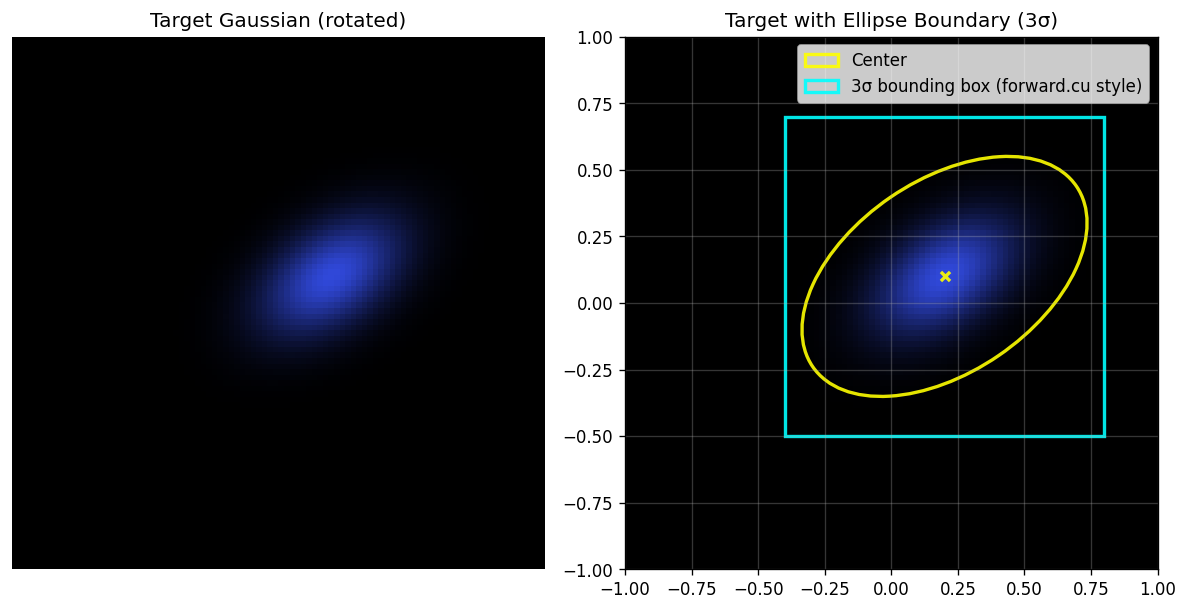

In [2]:
# Scene setup
H, W = 96, 96

n_sigma = 3.0  # match forward.cu convention (3σ coverage)

# Target: a single rotated Gaussian with purple color
# Use batched format (1, k) for consistency with render_gaussians_2d
target_mu = torch.tensor([[0.2, 0.1]], dtype=torch.float32)  # (1, 2)
target_sigma = torch.tensor([[0.2, 0.12]], dtype=torch.float32)  # (1, 2)
target_theta = torch.tensor([0.6], dtype=torch.float32)  # (1,) ~34 degrees rotation
target_opacity = torch.tensor([0.95], dtype=torch.float32)  # (1,) opacity
target_rgb = torch.tensor([[0.2, 0.3, 0.9]], dtype=torch.float32)  # (1, 3) Purple RGB

img_target_g = render_gaussians_2d(H, W, target_mu, target_sigma, target_theta, target_opacity, target_rgb)

# Visualize with and without ellipse boundary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Left: plain target image
ax1.imshow(img_target_g.detach().cpu().numpy(), interpolation="nearest")
ax1.set_title("Target Gaussian (rotated)")
ax1.axis('off')

# Right: target with ellipse boundary (explicit 3σ)
ax2.imshow(img_target_g.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', interpolation="nearest")
draw_gaussian_ellipses(ax2, target_mu, target_sigma, target_theta,
                       color='yellow', label='Center', alpha=0.9, n_sigma=n_sigma)

# forward.cu uses a 3σ bounding radius from the largest eigenvalue; emulate with an axis-aligned 3σ box
bbox_half = (torch.max(target_sigma) * n_sigma).item()
bbox = Rectangle((target_mu[0, 0].item() - bbox_half, target_mu[0, 1].item() - bbox_half),
                 width=2 * bbox_half,
                 height=2 * bbox_half,
                 edgecolor='cyan', facecolor='none', linewidth=2.0, alpha=0.9,
                 label='3σ bounding box (forward.cu style)')
ax2.add_patch(bbox)

ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_aspect('equal')
ax2.set_title('Target with Ellipse Boundary (3σ)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 2 — Triangle Fitting with Multiple Gaussian Splats

**Problem**: Use multiple Gaussian splats to approximate a triangle shape.

This demonstrates:
1. **Representation flexibility**: Gaussians can approximate other shapes
2. **Multi-primitive optimization**: Optimizing many Gaussians simultaneously
3. **Additive blending with separate opacity and color**: $I(\mathbf{p}) = \sum_{i=1}^{N} \alpha_i \cdot \text{rgb}_i \cdot f_i(\mathbf{p})$

**Challenge**: Triangles have hard edges, while Gaussians are smooth. We'll see how multiple Gaussians can work together to approximate sharp features.

In [3]:
# Helper function for triangle rendering (from 0202)
def edge_function(a, b, p):
    return (b[..., 0] - a[..., 0]) * (p[..., 1] - a[..., 1]) - (b[..., 1] - a[..., 1]) * (p[..., 0] - a[..., 0])

def barycentric_weights(v0, v1, v2, p):
    area = edge_function(v0, v1, v2)
    area = torch.where(torch.abs(area) < 1e-12, torch.tensor(1e-12, device=area.device), area)
    w0 = edge_function(v1, v2, p) / area
    w1 = edge_function(v2, v0, p) / area
    w2 = edge_function(v0, v1, p) / area
    return w0, w1, w2

def render_triangle_hard(H, W, verts, colors, background=(0.0, 0.0, 0.0)):
    """Hard-edge triangle rasterizer."""
    device = verts.device
    P = make_pixel_grid(H, W, device=device)
    v0, v1, v2 = verts[0], verts[1], verts[2]
    area = edge_function(v0, v1, v2)
    s = 1.0 if area >= 0 else -1.0
    e0 = s * edge_function(v0, v1, P)
    e1 = s * edge_function(v1, v2, P)
    e2 = s * edge_function(v2, v0, P)
    inside = (e0 >= 0) & (e1 >= 0) & (e2 >= 0)
    w0, w1, w2 = barycentric_weights(v0, v1, v2, P)
    rgb = (w0[..., None] * colors[0] + w1[..., None] * colors[1] + w2[..., None] * colors[2])
    rgb = torch.clamp(rgb, 0.0, 1.0)
    img = torch.zeros((H, W, 3), device=device, dtype=verts.dtype)
    img[...] = torch.tensor(background, device=device, dtype=verts.dtype)
    img[inside] = rgb[inside]
    return img

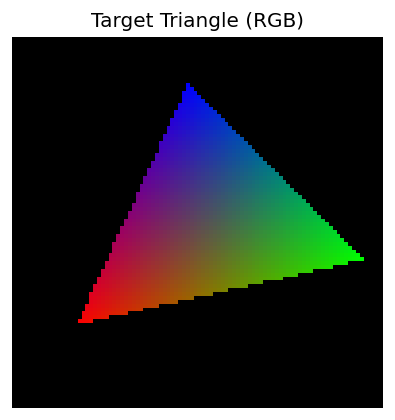

In [4]:
# Create target triangle
verts_target = torch.tensor([
    [-0.65, -0.55],
    [ 0.90, -0.20],
    [-0.05,  0.75],
], dtype=torch.float32)

colors_target = torch.tensor([
    [1.0, 0.0, 0.0],  # Red
    [0.0, 1.0, 0.0],  # Green
    [0.0, 0.0, 1.0],  # Blue
], dtype=torch.float32)

img_target_tri = render_triangle_hard(H, W, verts_target, colors_target)
show_images([img_target_tri], ["Target Triangle (RGB)"])


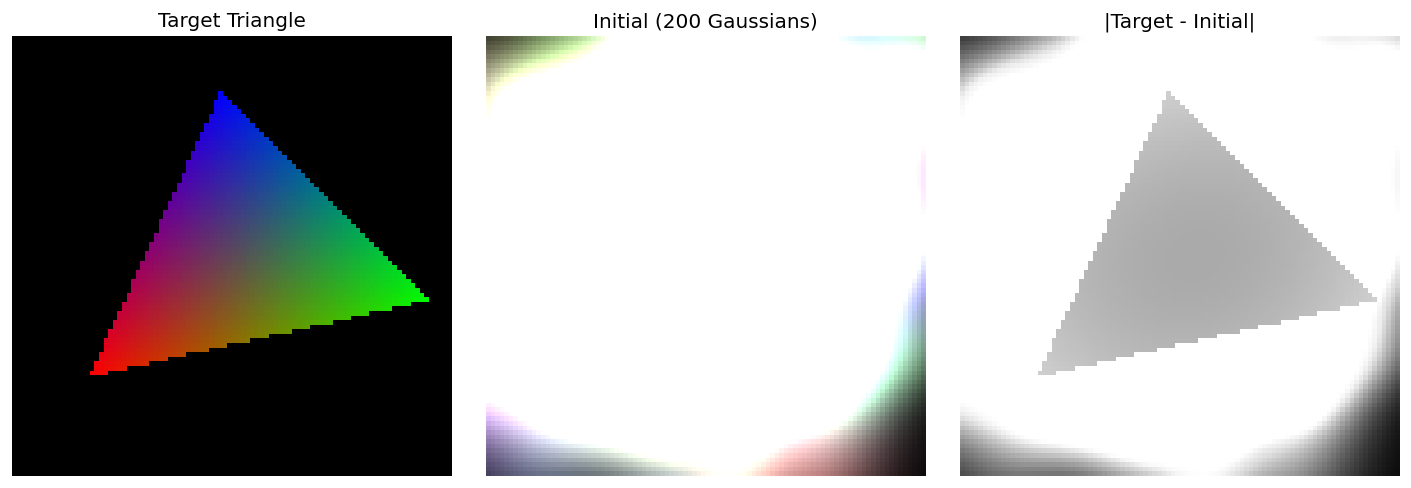

In [5]:
# Initialize multiple random Gaussians to fit the triangle
num_gaussians = 200  # Use multiple Gaussians to approximate the triangle

# Random initialization
torch.manual_seed(42)
init_mus = torch.randn(num_gaussians, 2) * 0.5
init_sigmas = torch.rand(num_gaussians, 2) * 0.2 + 0.1  # Random sizes
init_thetas = torch.rand(num_gaussians) * 2 * np.pi  # Random rotations [0, 2π]
init_opacities = torch.rand(num_gaussians) * 0.5 + 0.3  # Random opacities [0.3, 0.8]
init_rgbs = torch.rand(num_gaussians, 3) * 0.6 + 0.2  # Random RGB colors

img_init_tri = render_gaussians_2d(H, W, init_mus, init_sigmas, init_thetas, init_opacities, init_rgbs)
d_rgb_tri, d_mag_tri = diff_image(img_init_tri, img_target_tri)
show_images(
    [img_target_tri, img_init_tri, d_mag_tri],
    ["Target Triangle", f"Initial ({num_gaussians} Gaussians)", "|Target - Initial|"],
    figsize=(12, 4)
)

In [6]:
# Optimize multiple Gaussians to fit the triangle - now with rotation!
mus_param = init_mus.clone().detach().requires_grad_(True)
sigmas_param = init_sigmas.clone().detach().requires_grad_(True)
thetas_param = init_thetas.clone().detach().requires_grad_(True)
opacities_param = init_opacities.clone().detach().requires_grad_(True)
rgbs_param = init_rgbs.clone().detach().requires_grad_(True)

optimizer_tri = torch.optim.Adam([mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param], lr=0.01)

history_tri = []
snapshots_tri = []
snapshot_schedule_tri = {0, 1, 2, 5, 10, 20, 40, 80, 120, 160, 200, 250, 300, 350}

# Video frames
video_frames_tri = []
video_sample_rate = 3

# Snapshot initial state
snapshots_tri.append((0, mus_param.detach().clone(), sigmas_param.detach().clone(),
                     thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
video_frames_tri.append(img_init_tri.detach().cpu().numpy())

max_iters_tri = 100
print(f"Optimizing {num_gaussians} Gaussians (with rotation) to fit triangle...")
for it in range(max_iters_tri):
    optimizer_tri.zero_grad()
    
    # Clamp parameters to valid ranges
    with torch.no_grad():
        mus_param.clamp_(-1.5, 1.5)
        sigmas_param.clamp_(0.01, 1.0)
        opacities_param.clamp_(0.0, 1.0)
        rgbs_param.clamp_(0.0, 1.0)
        # No clamping for thetas - let them rotate freely
    
    # Render all Gaussians and compute loss
    img = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
    loss = torch.mean((img - img_target_tri) ** 2)
    
    # Backward pass
    loss.backward()
    optimizer_tri.step()
    
    # Record history
    history_tri.append(loss.item())
    
    # Take snapshots
    if (it + 1) in snapshot_schedule_tri:
        snapshots_tri.append((it + 1, mus_param.detach().clone(), sigmas_param.detach().clone(),
                             thetas_param.detach().clone(), opacities_param.detach().clone(), rgbs_param.detach().clone()))
    
    # Capture video frames
    if (it + 1) % video_sample_rate == 0:
        frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
        video_frames_tri.append(frame)
    
    if (it + 1) % 50 == 0:
        print(f"Iteration {it+1}/{max_iters_tri}, Loss: {loss.item():.6f}")

# Add final frame
final_frame = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param).detach().cpu().numpy()
video_frames_tri.append(final_frame)


print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Trained {num_gaussians} Gaussians to approximate triangle")

Optimizing 200 Gaussians (with rotation) to fit triangle...
Iteration 50/100, Loss: 0.007273
Iteration 100/100, Loss: 0.002425
Final loss: 0.002425
Trained 200 Gaussians to approximate triangle


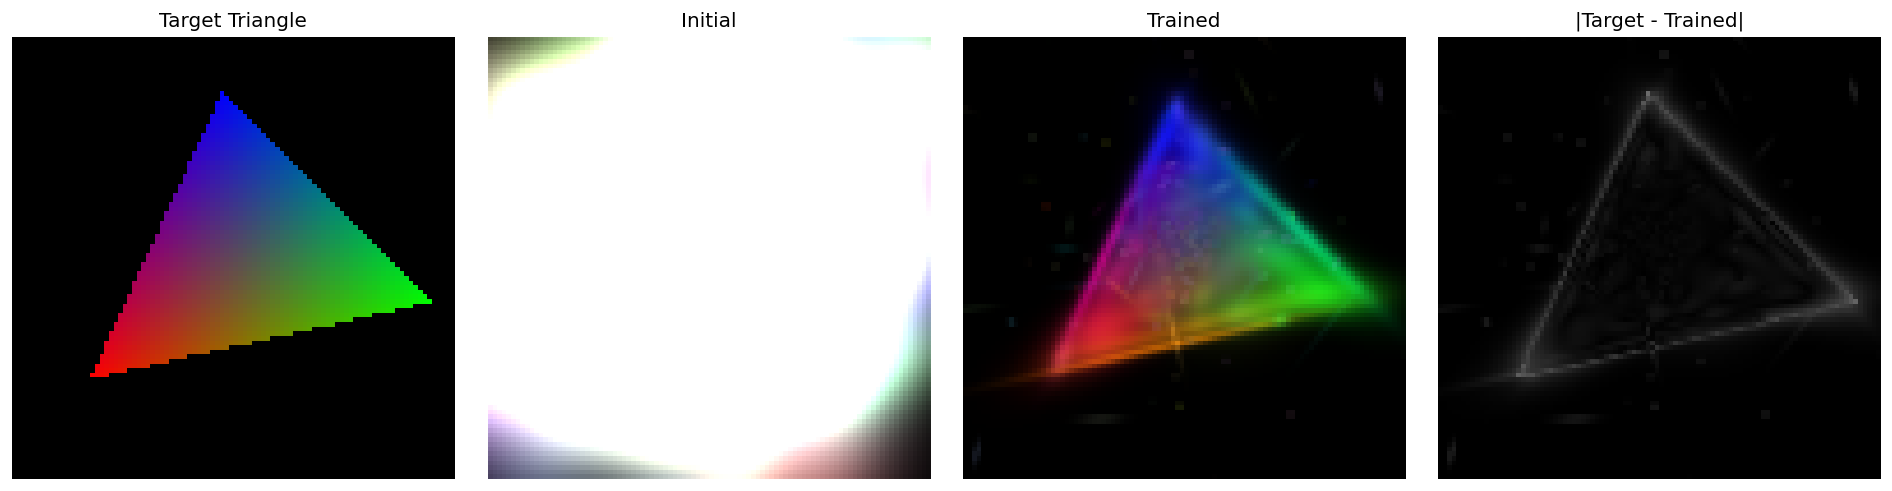

In [7]:
# Final result visualization
img_trained_tri = render_gaussians_2d(H, W, mus_param, sigmas_param, thetas_param, opacities_param, rgbs_param)
d_rgb_t, d_mag_t = diff_image(img_target_tri, img_trained_tri)

show_images(
    [img_target_tri, img_init_tri, img_trained_tri, d_mag_t],
    ["Target Triangle", "Initial", "Trained", "|Target - Trained|"],
    figsize=(16, 4)
)

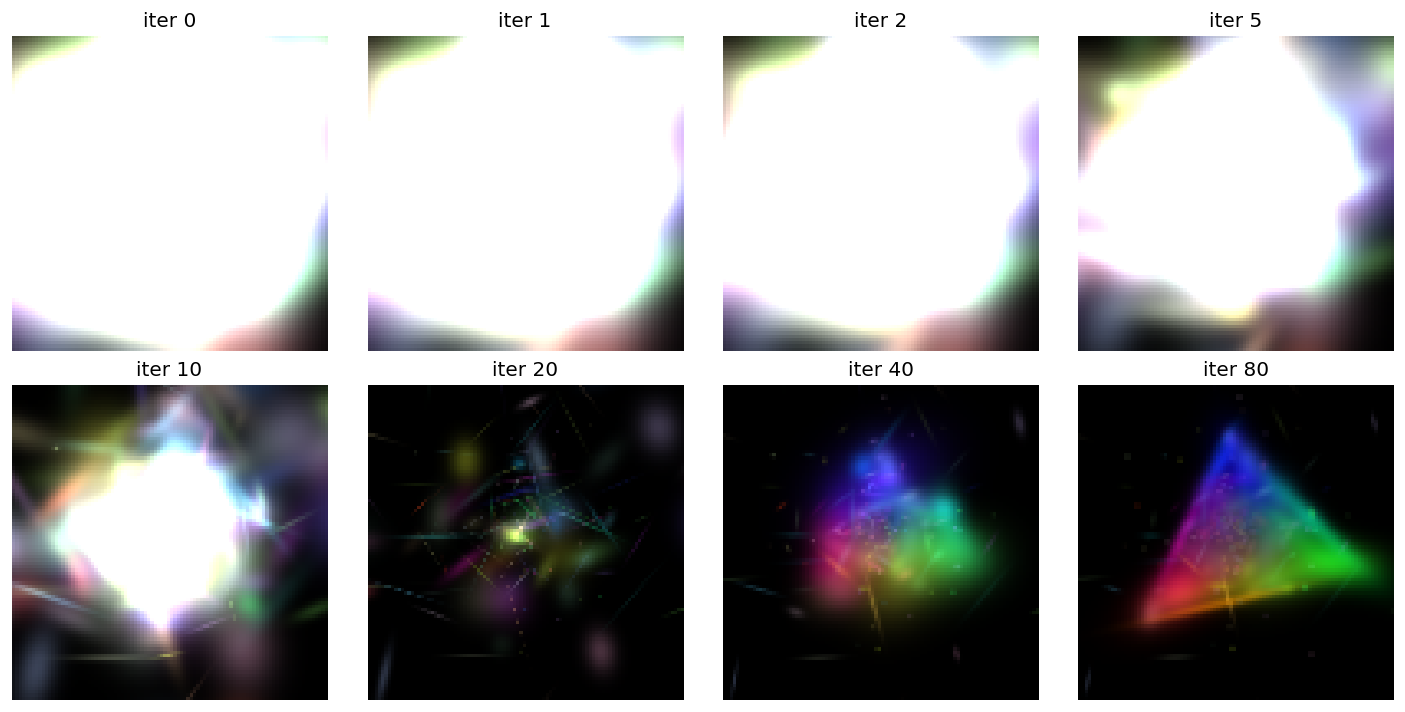

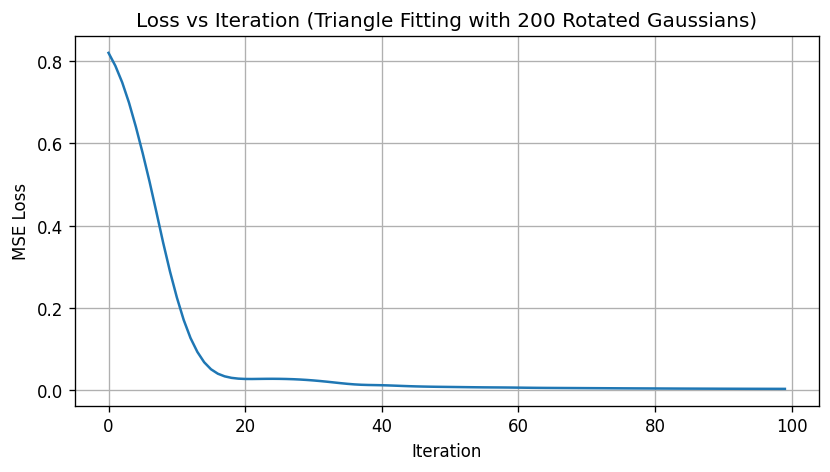

=== Optimization Results (Triangle Fitting with Rotation) ===
Number of Gaussians: 200
Initial loss: 0.820697
Final loss: 0.002425
Improvement: 99.70%
Key insight: Rotated Gaussians can better approximate oriented features!
Full 2×2 covariance matrices allow alignment with triangle edges.


In [8]:
# Show training snapshots for triangle fitting
seen = set()
snapshots_tri_unique = []
for snapshot in snapshots_tri:
    it = snapshot[0]
    if it not in seen:
        snapshots_tri_unique.append(snapshot)
        seen.add(it)
snapshots_tri_unique.sort(key=lambda t: t[0])

snap_imgs = []
snap_titles = []
for snapshot in snapshots_tri_unique:
    it, mus, sigmas, thetas, opacities, rgbs = snapshot
    snap_imgs.append(render_gaussians_2d(H, W, mus, sigmas, thetas, opacities, rgbs))
    snap_titles.append(f"iter {it}")
show_image_grid(snap_imgs, snap_titles, cols=4, cell_size=3.0)

# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(history_tri)
plt.title(f"Loss vs Iteration (Triangle Fitting with {num_gaussians} Rotated Gaussians)")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

print("=== Optimization Results (Triangle Fitting with Rotation) ===")
print(f"Number of Gaussians: {num_gaussians}")
print(f"Initial loss: {history_tri[0]:.6f}")
print(f"Final loss: {history_tri[-1]:.6f}")
print(f"Improvement: {(1 - history_tri[-1]/history_tri[0]) * 100:.2f}%")

print("Key insight: Rotated Gaussians can better approximate oriented features!")
print("Full 2×2 covariance matrices allow alignment with triangle edges.")

In [9]:
# Save and display training video for triangle fitting
print(f"Creating video with {len(video_frames_tri)} frames...")
save_training_video(video_frames_tri, "gaussian_triangle_training.mp4", fps=30, 
                   title=f"Triangle Fitting with {num_gaussians} Gaussians")
Video("gaussian_triangle_training.mp4", embed=True, width=600)

Creating video with 35 frames...
Video saved to gaussian_triangle_training.mp4


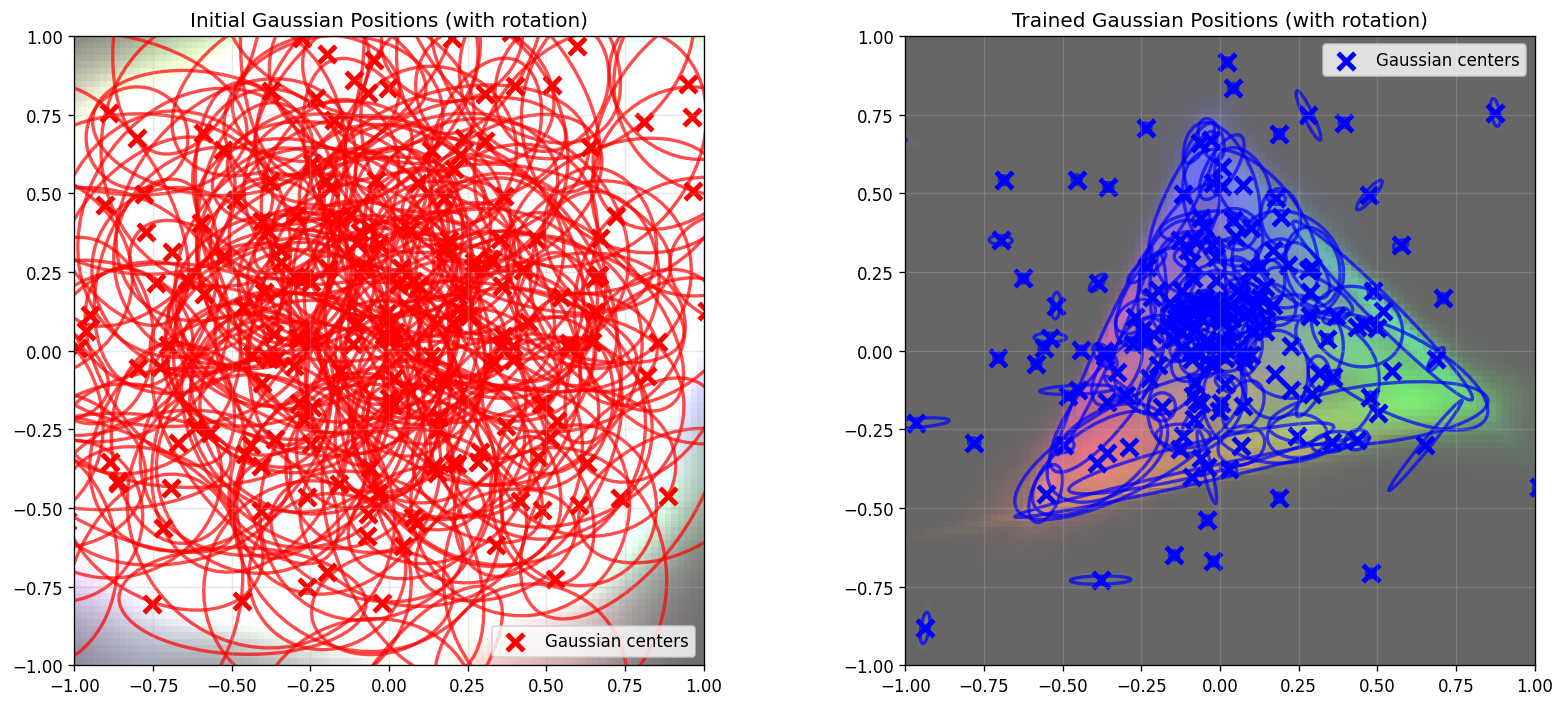

Notice how the Gaussians:
• Moved to concentrate around the triangle edges
• Adjusted their sizes to better cover the target shape
• Rotated to align with the triangle's oriented edges
• Changed colors to match the target RGB distribution


In [10]:
# Visualize Gaussian positions and their evolution with rotation
from matplotlib.patches import Ellipse

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Initial positions
mus_np = init_mus.detach().cpu().numpy()
ax1.imshow(img_init_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax1.scatter(mus_np[:, 0], mus_np[:, 1], c='red', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(num_gaussians):
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=init_sigmas[i, 0].item() * 3,
        height=init_sigmas[i, 1].item() * 3,
        angle=np.degrees(init_thetas[i].item()),  # Convert radians to degrees
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax1.add_patch(ellipse)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_aspect('equal')
ax1.set_title('Initial Gaussian Positions (with rotation)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final positions
mus_np = mus_param.detach().cpu().numpy()
ax2.imshow(img_trained_tri.detach().cpu().numpy(), extent=[-1, 1, -1, 1], origin='upper', alpha=0.6)
ax2.scatter(mus_np[:, 0], mus_np[:, 1], c='blue', s=100, marker='x', linewidths=3, label='Gaussian centers')
for i in range(num_gaussians):
    ellipse = Ellipse(
        (mus_np[i, 0], mus_np[i, 1]),
        width=sigmas_param[i, 0].item() * 3,
        height=sigmas_param[i, 1].item() * 3,
        angle=np.degrees(thetas_param[i].item()),  # Convert radians to degrees
        edgecolor='blue',
        facecolor='none',
        linewidth=2,
        alpha=0.7
    )
    ax2.add_patch(ellipse)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)
ax2.set_aspect('equal')
ax2.set_title('Trained Gaussian Positions (with rotation)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how the Gaussians:")
print("• Moved to concentrate around the triangle edges")
print("• Adjusted their sizes to better cover the target shape")
print("• Rotated to align with the triangle's oriented edges")
print("• Changed colors to match the target RGB distribution")

## 참고자료 (References)

**3D Gaussian Splatting for Real-Time Radiance Field Rendering (2023)**
- Kerbl et al., SIGGRAPH 2023
- [Paper](https://arxiv.org/abs/2308.04079) | [Project Page](https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/)
- Introduced Gaussian splatting for 3D scene representation